# Tutorial

This tutorial showcases the functionalities of *diskmap*. We will use a polarized scattered light image of the LkCa 15 circumstellar disk. The data were obtained with [VLT/SPHERE](https://www.eso.org/sci/facilities/paranal/instruments/sphere.html) in the $J$ band and have been published by [Thalmann et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...828L..17T/abstract).

## Getting started

We start by importing the Python modules that are required for this tutorial.

In [1]:
import diskmap
import glob
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from astropy.io import fits

Next, we download the $J$ band image of LkCa 15 circumstellar disk.

In [2]:
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/diskmap/lkca15_irdis_qphi.fits',
                           'lkca15_irdis_qphi.fits')

('lkca15_irdis_qphi.fits', <http.client.HTTPMessage at 0x12c06f6a0>)

We can read the FITS file with `astropy`.

In [3]:
image = fits.getdata('lkca15_irdis_qphi.fits')

Let's have a look at the image. The central masked region contains NaNs.

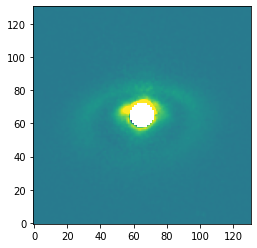

In [4]:
plt.imshow(image, origin='lower', vmin=np.nanmin(image), vmax=0.35*np.nanmax(image))

## Mapping of the disk surface

We will now create an instance of `DiskMap` by providing the FITS filename, the pixel scale of the detector (12.25 mas for SPHERE/IRDIS), the inclination (50 deg) and position angle (90 deg) of the disk, the distance (160 pc), and the image type (polarized flux).

The inclination convention is such that the near side is located on the right side of the image when using an inclination between 0 and 90 deg and a position angle of 0 deg. Therefore, with an position angle of 90 deg, the near side will be in upward direction of the image, as we will also see later in the `_radius.fits` file.

In [5]:
mapping = diskmap.DiskMap(fitsfile='lkca15_irdis_qphi.fits',
                          pixscale=0.01225,
                          inclination=50.,
                          pos_angle=90.,
                          distance=160.,
                          image_type='polarized')

The scattering surface of the disk is mapped with the `map_disk` method. The height of the scattering surface is parametrized with a power-law funtion, $h(r) = a + b*(r/1\,\mathrm{au})^c$, with $a$, $b$, $r$, and $h(r)$ in au, and is set with the argument of `power_law` as `(a, b, c)`. In this example, we assume a constant opening angle for the disk surface: $h(r) = 0 + 0.05r^{1}$. The argument of `radius` specifies the sampling of the radii, here 100 points between 1 and 500 au.

For running the deprojection later on, it is important that the outer radius of the `radius` parameter is larger than the field of view of the image. This may not be possible if the disk is strongly inclined and flaring. A mapping of the full field of view is not required for the $r^2$ scaling and phase function extraction. In that case, a smaller outer radius can be used, for example the actual outer radius of the disk. The radius and scattering angle output will contain NaNs beyond the outer radius.

In [6]:
mapping.map_disk(power_law=(0., 0.05, 1.),
                 radius=(1., 500., 100))

## Radius and scattering angle

The available output from the `DiskMap` methods are written by calling `write_output`. The argument of `filename` contains the prefix of the output files.

In [7]:
mapping.write_output(filename='lkca15')

Let's see which FITS files have been written.

In [8]:
glob.glob('*.fits')

['lkca15_irdis_qphi.fits', 'lkca15_radius.fits', 'lkca15_scat_angle.fits']

For simplicity with the plots, we define half the field of view in arcseconds.

In [9]:
size = mapping.pixscale * image.shape[0]/2

The deprojected radius (in au) from the disk surface to the star is stored in the `_radius.fits` file. Let's plot the image from this FITS file.

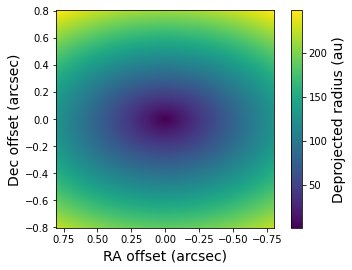

In [10]:
radius = fits.getdata('lkca15_radius.fits')
plt.imshow(radius, origin='lower', extent=[size, -size, -size, size])
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='Deprojected radius (au)', size=14)

Similarly, the scattering angles on the disk surface are stored in the `_scat_angle.fits` file. The scattering angle is defined as 180 degrees minus the angle between the direction from the disk surface to the star and the direction from the disk surface to the observer.

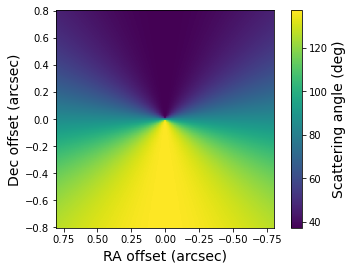

In [11]:
scat_angle = fits.getdata('lkca15_scat_angle.fits')
plt.imshow(scat_angle, origin='lower', extent=[size, -size, -size, size])
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='Scattering angle (deg)', size=14)

## Irradiation correction

Now that we have the deprojected distance from each pixel to the star, we can compute the stellar irradiation corrected (i.e. $r^2$ scaled) image. We set a maximum radius of 100 au such that the flux at large separations, which only consists of noise, is not enhanced by the scaling.

In [12]:
mapping.r2_scaling(r_max=100.)

We run again the `write_output` method such that also the r$^2$ scaled image is stored as FITS file.

In [13]:
mapping.write_output(filename='lkca15')

Let's have a look at the r$^2$ scaled image. The dynamical range is smaller compared to the regular image which brings out the disk features more clearly.

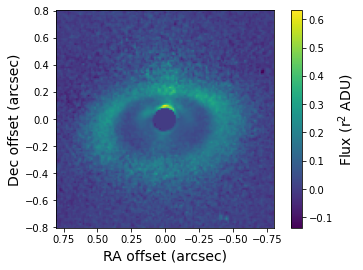

In [14]:
r2_scaled = fits.getdata('lkca15_r2_scaled.fits')
plt.imshow(r2_scaled, origin='lower', extent=[size, -size, -size, size])
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='Flux (r$^2$ ADU)', size=14)

## Disk deprojection

Next, we will use the 3D mapping of the disk surface to deproject the image with the `deproject_disk` method. The deprojection corrects therefore both for the inclination (i.e. the disk midplane) and height of the disk surface (i.e. the powerlaw profile).

In [15]:
mapping.deproject_disk()

And we write again all available output files.

In [16]:
mapping.write_output(filename='lkca15')

The deprojected image is stored in the FITS file with the `_deprojected.fits` suffix. This image shows what the disk would look like at an inclination of 0 degrees. Let's have a look at the result.

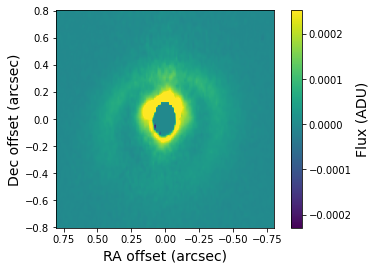

In [17]:
deprojected = fits.getdata('lkca15_deprojected.fits')
plt.imshow(deprojected, origin='lower', extent=[size, -size, -size, size],
           vmin=np.amin(deprojected), vmax=0.25*np.amax(deprojected))
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='Flux (ADU)', size=14)

## Estimated total intensity image

By assuming a bell-shaped (i.e. Rayleigh-like curve with an adjustable peak value) degree of polarization and using the scattering angles from before, we use the `total_intensity` method to convert the r$^2$-scaled, polarized intensity image into an estimated total intensity image. This method should therefore only be used if the input image is a polarized light image (i.e. `image_type='polarized'`).

In this example, we assume a maximum polarization of 100% at a scattering angle of 90 degrees, which is to be expected for aggregate-like dust grains with submicron-sized monomers.

In [18]:
mapping.total_intensity(pol_max=1.)

We write again all available output, which now also includes the r$^2$-scaled, total intensity image.

In [19]:
mapping.write_output(filename='lkca15')

Let's plot the total intensity image. The forward scattering by dust grains on the near/north side of the disk is visible in this image.

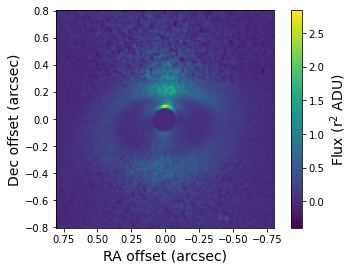

In [20]:
total_intensity = fits.getdata('lkca15_total_intensity.fits')
plt.imshow(total_intensity, origin='lower', extent=[size, -size, -size, size])
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='Flux (r$^2$ ADU)', size=14)

## Scattering phase function

As a last step, we extract the scattering phase function from, that is, the normalized flux as function of scattering angle. We use the `phase_function` method and select pixels between a deprojected distance of 80 and 100 au (i.e. along the bright ring in the r$^2$-scaled image) and caculate the average flux in 30 steps between 0 and 180 degrees.

In [21]:
mapping.phase_function(radius=(80., 100.), n_phase=30)

We run again the `write_output` method to store the phase function in a text file.

In [22]:
mapping.write_output(filename='lkca15')

We can read the extracted phase function with the `loadtxt` function of `numpy`. The second and third column of the data file contain the extracted phase function and error, which in this case is the polarized phase function. The fourth and fifth column contains an extimated total intensity phase function, which assumes that the degree of polarization is bell-shaped.

In case the input image is a total intensity image (i.e. `image_type='total'`), the data file contains only the regular / total intensity phase function.

In [23]:
angle, pol_flux, pol_error, total_flux, total_error = np.loadtxt('lkca15_phase_function.dat', unpack=True)

Let's plot the polarized phase function that is extracted from the r$^2$-scaled image.

Text(0, 0.5, 'Normalized polarized flux')

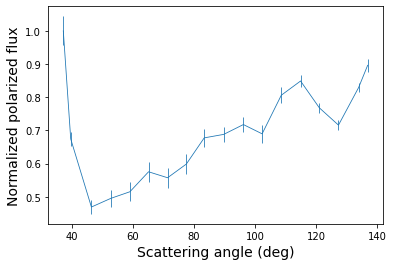

In [24]:
plt.errorbar(angle, pol_flux, yerr=pol_error)
plt.xlabel('Scattering angle (deg)', fontsize=14)
plt.ylabel('Normalized polarized flux', fontsize=14)

Finally, we plot the total intensity phase function, which shows the onset of a strong forward scattering peak and a more shallow backward scattering peak.

Text(0, 0.5, 'Normalized total flux')

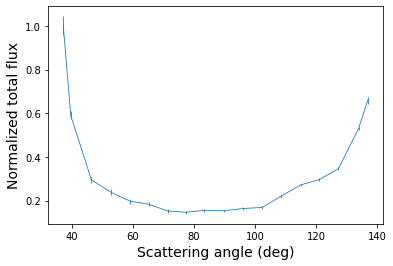

In [25]:
plt.errorbar(angle, total_flux, yerr=total_error)
plt.xlabel('Scattering angle (deg)', fontsize=14)
plt.ylabel('Normalized total flux', fontsize=14)